# Table of Contents
#### [파생변수 설명](#파생변수-설명)
#### 1. [Import Library](#[1]-Import-Library)
#### 2. [Load File](#[2]-Load-File)
#### 3. [Preprocessing](#[3]-Preprocessing)
  + [3.1 유동인구 DataFrame에 시간대별 유동인구 컬럼 생성](#3.1-용인시-유동인구(yi_7)-DataFrame에-시간대별-유동인구-컬럼-생성)
  + [3.2 소상공인 매출정보 데이터프레임 병합](#3.2-소상공인-매출정보-데이터프레임-병합)
  + [3.3 Geometry 데이터 형식을 좌표 형식으로 변경](#3.3-Multipolygon-데이터-형식을-Coordinates-형식으로-변경)
  + [3.4 그리드 내 위치정보를 시간대별 유동인구수로 점수 부여](#3.4-그리드-내-위치정보를-시간대별-유동인구수로-점수-부여)
  + [3.5 분석에 활용할 파생변수 생성](#3.5-분석에-활용할-파생변수-생성)
  + [3.6 yi_1_gid DataFrame 생성](#3.6-yi_1_gid-DataFrame-생성)
  + [3.7 분석을 위한 yong_analysis DataFrame 생성](#3.7-분석을-위한-yong_analysis-DataFrame-생성)

  
#### 4. [Analysis](#[4]-Analysis)
  + [4.1 RandomForestRegressor 모델 활용](#4.1-RandomForestRegressor-모델-활용)
    + [4.1.1 GridSerachCV로 최적값을 찾은 후 RandomForestRegressor 모델 적용](#4.1.1-GridSerachCV로-최적값을-찾은-후-RandomForestRegressor-모델-적용)
    + [4.1.2 RF 모델에 최적값 적용](#4.1.2-RF-모델에-최적값-적용)
    + [4.1.3 특성 중요도 시각화](#4.1.3-특성-중요도-시각화)
  + [4.2 사업체 실태 시각화](#4.2-사업체-실태-시각화)
    + [4.2.1 사업체 현황](#4.2.1-사업체-현황(사업연차,-휴폐업-비율))
  + [4.3 상관관계 분석](#4.3-상관관계-분석)
    + [4.3.1 Heatmap을 통한 상관관계 시각화](#4.3.1-Heatmap을-통한-상관관계-시각화)
    + [4.3.2 pairplot을 통한 상관관계 시각화](#4.3.2-pairplot을-통한-상관관계-시각화)

#### 5. [창업 아이디어 제시를 위한 좋은 격자 찾기](#[5]-창업-아이디어-제시를-위한-좋은-격자-찾기)
  + [5.1 상위 25% 이상 격자 시각화](#5.1-상위-25%-이상-격자-시각화)
    + [5.1.1 총유동인구수(total_fp) 상위 25% 이상 격자](#5.1.1-총유동인구수(total_fp)-상위-25%-이상-격자)
    + [5.1.2 총매출량(total_volume) 상위 25% 이상 격자](#5.1.2-총매출량(total_volume)-상위-25%-이상-격자)
    + [5.1.3 총인구수(total_pop) 상위 25% 이상 격자](#5.1.3-총인구수(total_pop)-상위-25%-이상-격자)
    + [5.1.4 위 3개 조건을 모두 만족하는 격자](#5.1.4-위-3개-조건을-모두-만족하는-격자)
  + [5.2 아파트 상권 TOP20 격자](#5.2-아파트-상권-TOP20-격자)
    + [5.2.1 아파트 상권 격자 경쟁업체 수](#5.2.1-아파트-상권-격자-경쟁업체-수)
    + [5.2.2 아파트 상권 격자 추출](#5.2.2-아파트-상권-격자-추출)
  + [5.3 오피스 상권 격자](#5.3-오피스-상권-격자)
    + [5.3.1 오피스 상권 TOP20 격자](#5.3.1-오피스-상권-TOP20-격자)
    + [5.3.2 yongsales 격자 내 산업단지 격자](#5.3.2-yongsales-격자-내-산업단지-격자)

## 파생변수 설명
* total_volume: 총매출액
* coordinates: Geometry 데이터 형식을 좌표 형식으로 변경
* 매출정보 격자 내 유동인구의 지역정보가 포함되어 있으면 점수로 부여
  - Ah(아침): 08시~11시
  - Jum(점심): 12시~15시
  - Ju(저녁): 17시~20시
  - Rest(나머지 시간대): 16시, 21시~07시
* total_fp: 총 유동인구 수
* total_pop: 매출정보 격자 내 총 인구 수의 그리드의 평균이 포함되어 있으면 점수로 부여
* runout_percent: 격자 내 사업체 수 대비 휴폐업 사업장 수
* guarantee_score: 사업장 유지년도에 따른 차등 점수 지표

## [1] Import Library

In [6]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation, manipulation
from matplotlib import font_manager, rc
from glob import glob
from ast import literal_eval
import matplotlib.pyplot as plt
import matplotlib
import sys
import platform
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import folium
from tqdm import tqdm_notebook

plt.style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
%matplotlib inline

# 한글 깨지는 현상 방지
f_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family=font_name)

# 마이너스 부호 깨지는 현상 방지
matplotlib.rcParams['axes.unicode_minus'] = False

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# regression
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor

# pandas set options
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## [2] Load File

In [21]:
file_list1 = glob('../data/yongin/*.geojson')
file_list2 = glob('../data/yongin/*용인시*.csv')

In [22]:
num1 = []
for i in range(len(file_list1)):
    num1.append(file_list1[i].split('.')[0][5:])

num2 = []
for i in range(len(file_list2)):
    num2.append(file_list2[i].split('.')[0][5:])

In [23]:
mod = sys.modules[__name__]

for i in range(len(file_list1)):
    setattr(mod, 'yi_{}'.format(num1[i]), gpd.read_file(file_list1[i]))

for i in range(len(file_list2)):
    setattr(mod, 'yi_{}'.format(num2[i]),
            pd.read_csv(file_list2[i], encoding='utf-8'))

In [24]:
import os
os.getcwd()

'C:\\Users\\USER\\Anaconda3\\DataScience\\yongin'

## [3] Preprocessing

### 3.1 용인시 유동인구(yi_7) DataFrame에 시간대별 유동인구 컬럼 생성

In [10]:
col_list = []
for col in yi_7.columns:
    if col.split('_')[0] == 'TMST':
        col_list.append(col)

NameError: name 'yi_7' is not defined

In [8]:
for i in yi_7.columns:
    yi_7[i] = yi_7[i].astype('float')
    
#시간대별 새로운 column 생성
yi_7['Ah'] = yi_7['TMST_08'] + yi_7['TMST_09'] + yi_7['TMST_10'] + yi_7['TMST_11']
yi_7['Jum'] = yi_7['TMST_12'] + yi_7['TMST_13'] + yi_7['TMST_14'] + yi_7['TMST_15']
yi_7['Ju'] = yi_7['TMST_17'] + yi_7['TMST_18'] + yi_7['TMST_19'] + yi_7['TMST_20']
yi_7['Rest'] = yi_7[col_list].sum(axis=1) - yi_7['Ah'] - yi_7['Jum'] - yi_7['Ju']

#### 용인시 전체 격자와 yi_7의 위치정보를 함께 시각화

In [7]:
center = (37.2410864, 127.1775537)
zoom = 11

m = folium.Map(location=center,
               zoom_start=zoom,
               tiles='http://api.vworld.kr/req/wmts/1.0.0/8A493903-DE32-3DB0-AD78-4ECBE52B86D3/\
               gray/{z}/{y}/{x}.png',
               attr='용인시'
               )
folium.GeoJson(yi_4).add_to(m)

for n in range(10000):
    folium.CircleMarker([yi_7['lat'][n], yi_7['lon'][n]],
                        color='red', radius=3).add_to(m)

m.save('html/yi_7.html')

### 3.2 소상공인 매출정보 데이터프레임 병합

In [9]:
raw_yongsales = pd.merge(yi_17, yi_16[['gid', 'geometry']],
                         on='gid', how='left')
raw_yongsales = gpd.GeoDataFrame(raw_yongsales)

### 3.3 Multipolygon 데이터 형식을 Coordinates 형식으로 변경

In [10]:
def multipolygon_to_coordinates(x):
    lon, lat = x[0].exterior.xy
    return [[x, y] for x, y in zip(lon, lat)]

In [11]:
# Coordinates로 변경하기 위해 DataFrame 복사
yongsales = raw_yongsales[:]

yongsales['coordinates'] = yongsales['geometry'].apply(
    multipolygon_to_coordinates)

# 중복되는 마지막 요소 제거
for i in range(len(yongsales['coordinates'])):
    del yongsales['coordinates'][i][-1]

### 3.4 그리드 내 위치정보를 시간대별 유동인구수로 점수 부여

In [ ]:
Ah_list = []
Jum_list = []
Ju_list = []
Rest_list = []

for i in tqdm_notebook(range(len(yongsales))):
    Ah, Jum, Ju, Rest = 0, 0, 0, 0
    for j in range(len(yi_7)):
        if (yongsales['coordinates'][i][0][0] < yi_7['lon'][j]) & (
                yi_7['lon'][j] < yongsales['coordinates'][i][2][0]):
            if (yongsales['coordinates'][i][0][1] < yi_7['lat'][j]) & (
                    yi_7['lat'][j] < yongsales['coordinates'][i][2][1]):
                Ah += yi_7['Ah'][j]
                Jum += yi_7['Jum'][j]
                Ju += yi_7['Ju'][j]
                Rest += yi_7['Rest'][j]

    Ah_list.append(Ah)
    Jum_list.append(Jum)
    Ju_list.append(Ju)
    Rest_list.append(Rest)

yongsales['Ah'] = Ah_list
yongsales['Jum'] = Jum_list
yongsales['Ju'] = Ju_list
yongsales['Rest'] = Rest_list

### 3.5 분석에 활용할 파생변수 생성

#### total_volume: 총매출액

In [12]:
yongsales['total_volume'] = yongsales.iloc[:, 23:38].sum(axis=1)

#### guarantee_score: 사업연차별로 가중치를 주어 점수로 계산

In [13]:
yongsales['guarantee_score'] = ((yongsales['found_age_6'] * 6) + (yongsales['found_age_5'] * 5) +
                                (yongsales['found_age_4'] * 4) + (yongsales['found_age_3'] * 3) +
                                (yongsales['found_age_2'] * 2) +
                                (yongsales['found_age_1'] * 1)
                                ) / yongsales['ws_cnt']

#### runout_percent: 휴폐업 사업장 수 / 격자 내 사업장 수

In [14]:
yongsales['runout_percent'] = yongsales['runout_cnt'] / yongsales['ws_cnt'] * 100

#### 총인구수 격자정보의 평균을 파생변수로 추가

In [15]:
# 총인구수
notna_yi_3 = yi_3[:]

notna_yi_3['coordinates'] = notna_yi_3['geometry'].apply(
    multipolygon_to_coordinates)

for i in range(len(notna_yi_3['coordinates'])):
    del notna_yi_3['coordinates'][i][-1]

# 총인구수 df의 격자 내 인구수가 Nan값이거나 0인 경우를 제외
notna_yi_3 = notna_yi_3[notna_yi_3.val.notna() & notna_yi_3.val != 0]
notna_yi_3.reset_index(inplace=True, drop=True)

In [16]:
# 격자정보의 평균을 notna_yi_3의 mean_lat, mean_lon 컬럼으로 추가
lon_list = []
lat_list = []

for i in range(len(notna_yi_3)):
    lon, lat = 0, 0

    for j in range(4):
        lon += notna_yi_3['coordinates'][i][j][0]
        lat += notna_yi_3['coordinates'][i][j][1]

    lon /= 4
    lat /= 4
    lon_list.append(lon)
    lat_list.append(lat)

notna_yi_3['mean_lon'] = lon_list
notna_yi_3['mean_lat'] = lat_list

In [ ]:
# 격자정보의 평균이 매출정보 그리드 내에 존재할 경우
# 해당 격자 내 인구수를 yongsales의 total_pop 컬럼으로 추가
pop = 0
pop_list = []

for i in tqdm_notebook(range(len(raw_yongsales))):
    pop = 0
    for j in range(len(notna_yi_3)):
        if (yongsales['coordinates'][i][0][0] < notna_yi_3['mean_lon'][j]) & (
                notna_yi_3['mean_lon'][j] < yongsales['coordinates'][i][2][0]):

            if (yongsales['coordinates'][i][0][1] < notna_yi_3['mean_lat'][j]) & (
                    notna_yi_3['mean_lat'][j] < yongsales['coordinates'][i][2][1]):
                pop += notna_yi_3.val[j]

    pop_list.append(pop)

yongsales['total_pop'] = pop_list

In [ ]:
yongsales.to_csv('output/yongsales.csv', index=False)

### 3.6 yi_1_gid DataFrame 생성
yongsales의 coordinates와 매치되는 상권정보 데이터(yi_1)의 위도, 경도를 찾아 yi_1_gid DataFrame에 gid 컬럼을 추가

In [ ]:
yongsales = pd.read_csv('output/yongsales.csv')
yongsales['coordinates'] = yongsales['coordinates'].apply(literal_eval)

In [ ]:
# gid 컬럼을 yi_1에 추가하기 위해 데이터프레임 복사
yi_1_gid = yi_1[:]
yi_1_gid['gid'] = ''

In [ ]:
for i in tqdm_notebook(range(len(yongsales))):
    for j in range(len(yi_1)):
        if (yongsales['coordinates'][i][0][0] < yi_1['경도'][j]) & (
                yi_1['경도'][j] < yongsales['coordinates'][i][2][0]):
            if (yongsales['coordinates'][i][0][1] < yi_1['위도'][j]) & (
                    yi_1['위도'][j] < yongsales['coordinates'][i][2][1]):
                yi_1_gid['gid'][j] = yongsales['gid'][i]

In [ ]:
yi_1_gid.to_csv('output/yi_1_gid.csv', index=False)

### 3.7 분석을 위한 yong_analysis DataFrame 생성

In [ ]:
yong_analysis = yongsales[:]

# 분석에 필요 없는 컬럼 제거
yong_analysis.drop(['runout_cnt', 'geometry', 'coordinates', 'sme_loan_cnt'],
                   axis=1, inplace=True)

for col in yong_analysis.columns:
    if col.split('_')[0] == 'found':
        del yong_analysis[col]
    elif col.split('_')[0] == 'sales':
        del yong_analysis[col]
    elif col.split('_')[0] == 'rpr':
        del yong_analysis[col]
    elif col.split('f')[0] == 'high_':
        del yong_analysis[col]

# 업종코드 컬럼(indcd_)제거
for each in yong_analysis.columns:
    if each.split('_')[0] == 'indcd':
        del yong_analysis[each]

# 총 유동인구 수 컬럼 생성
yong_analysis['total_fp'] = yong_analysis[[
    'Ah', 'Jum', 'Ju', 'Rest']].sum(axis=1)

# yong_analysis 파일을 csv 형식으로 저장
yong_analysis.to_csv('output/yong_analysis.csv', index=False)

## [4] Analysis

### 4.1 RandomForestRegressor 모델 활용

#### 4.1.1 GridSerachCV로 최적값을 찾은 후 RandomForestRegressor 모델 적용

In [71]:
yong_analysis = pd.read_csv('output/yong_analysis.csv')

In [72]:
list = ['gid', 'rpr', 'sales', 'indcd', 'mean']

RFyong = yongsales[:]

for i in RFyong.columns:
    if i.split('_', 2)[0] in list:
        del RFyong[i]
        
RFyong.drop(['runout_cnt', 'sme_loan_cnt', 'geometry', 'coordinates', 
             'smbiz_yn_cnt','total_volume'], axis=1, inplace=True)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    RFyong, yong_analysis['total_volume'], random_state=0, test_size=0.1)

In [27]:
kfold = KFold(n_splits=5)

param_grid = {'max_features': ["auto"],
              'n_estimators': range(300, 500, 2)}

In [28]:
grid_search_RF = GridSearchCV(RandomForestRegressor(
    random_state=0), param_grid=param_grid, cv=kfold)

In [ ]:
grid_search_RF.fit(X_train, y_train)

In [ ]:
print(grid_search_RF.best_params_)
print(grid_search_RF.best_score_)

In [29]:
RF = RandomForestRegressor(n_estimators=326, random_state=0, max_features='auto')

In [30]:
RF.fit(X_train, y_train)

RandomForestRegressor(n_estimators=326, random_state=0)

In [31]:
RF.score(X_test,y_test)

0.8743162917920346

In [73]:
RFyong.to_csv('output/RFyong.csv', index=False)

#### 4.1.2 특성 중요도 시각화

In [32]:
fi = pd.DataFrame(RF.feature_importances_)
fi['names'] = RFyong.columns
fi.rename(columns={0:'count'},inplace = True)
fi.sort_values('count', inplace = True)

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


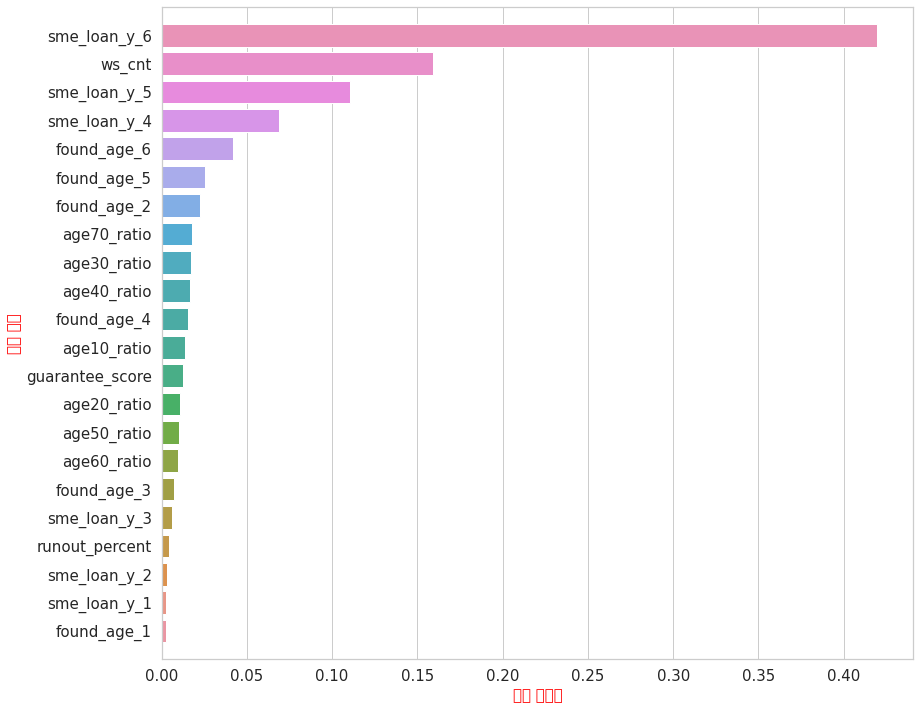

In [33]:
def plot_feature_importances(model):
    n_features = fi.shape[0]
    plt.figure(figsize=(12, 12))
    sns.barplot(x='count', y='names', data=fi)
    plt.yticks(np.arange(n_features), fi.names, fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlabel('특성 중요도', fontsize=15, c='red')
    plt.ylabel('특성 이름', fontsize=15, c='red')
    plt.ylim(-1, n_features)
    plt.show()

plot_feature_importances(RF)

### 4.2 사업체 실태 시각화

#### 4.2.1 사업연차별 사업체 현황

In [34]:
found_age = pd.DataFrame(yongsales[['found_age_1', 'found_age_2', 'found_age_3',
                                    'found_age_4', 'found_age_5', 'found_age_6', 'runout_cnt']].sum())

In [35]:
found_age.reset_index(inplace=True)
found_age = found_age.rename(columns = {'index': 'found_age', 0: 'sum'})

In [36]:
found_age

,found_age,sum
0,found_age_1,824
1,found_age_2,2784
2,found_age_3,2752
3,found_age_4,2384
4,found_age_5,1892
5,found_age_6,11929
6,runout_cnt,840


#### 4.2.2 대출금액별 사업체 현황

In [37]:
sme_loan_y = pd.DataFrame(yong_analysis[['sme_loan_y_1', 'sme_loan_y_2',
                                         'sme_loan_y_3', 'sme_loan_y_4', 'sme_loan_y_5', 'sme_loan_y_6']].sum())

In [38]:
sme_loan_y.reset_index(inplace=True)
sme_loan_y = sme_loan_y.rename(columns = {'index': 'sme_loan_y', 0: 'sum'})

In [39]:
sme_loan_y

,sme_loan_y,sum
0,sme_loan_y_1,609
1,sme_loan_y_2,588
2,sme_loan_y_3,1065
3,sme_loan_y_4,2386
4,sme_loan_y_5,1346
5,sme_loan_y_6,2340


### 4.3 상관관계 분석

#### 4.3.1 Heatmap을 통한 상관관계 시각화

In [40]:
heatmap = yong_analysis[:]
for i in heatmap.columns:
    if i.split('_')[0] == 'sme':
        del heatmap[i]
        
heatmap.drop(['Ah', 'Jum', 'Ju', 'Rest'], axis=1, inplace=True)

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


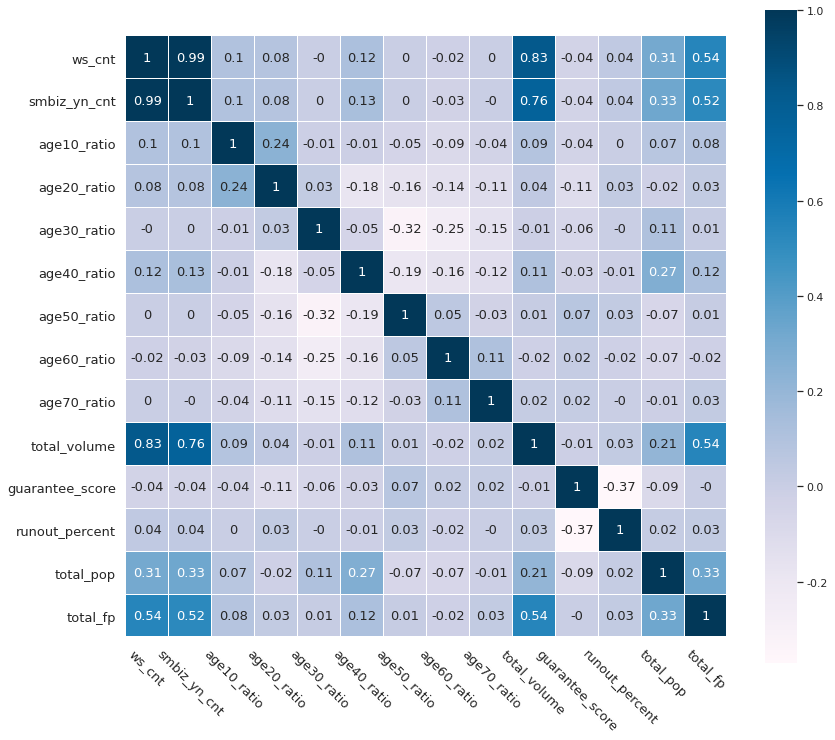

In [41]:
colormap = plt.cm.PuBu
plt.rcParams['figure.figsize'] = [12, 12]
sns.heatmap(round(heatmap.corr(), 2), linewidths=0.1,
            vmax=1.0, square=True, cmap=colormap, annot_kws={'size': 13},
            linecolor="white", annot=True)
plt.xticks(rotation=-45, fontsize=13)
plt.yticks(fontsize=13)
plt.show()

#### 4.3.2 pairplot을 통한 상관관계 시각화

In [42]:
df = yong_analysis.loc[:, ['ws_cnt', 'total_volume',
                           'guarantee_score', 'total_fp', 'total_pop', 'sme_loan_y_6']]

In [43]:
df.corr()

,ws_cnt,total_volume,guarantee_score,total_fp,total_pop,sme_loan_y_6
ws_cnt,1.000,0.833,-0.039,0.541,0.305,0.851
total_volume,0.833,1.000,-0.013,0.539,0.213,0.887
guarantee_score,-0.039,-0.013,1.000,-0.004,-0.092,-0.008
total_fp,0.541,0.539,-0.004,1.000,0.325,0.520
total_pop,0.305,0.213,-0.092,0.325,1.000,0.208
sme_loan_y_6,0.851,0.887,-0.008,0.520,0.208,1.000


<Figure size 864x864 with 0 Axes>

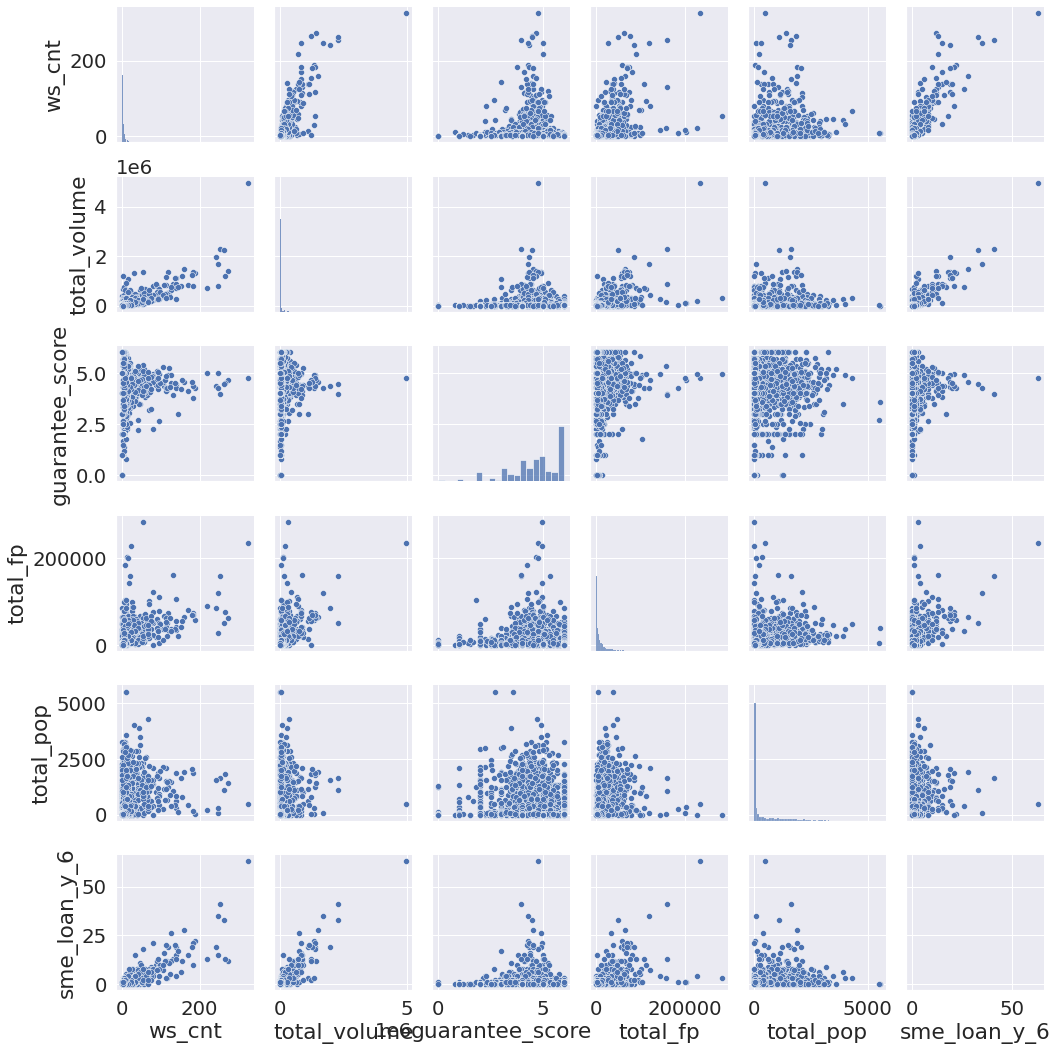

In [44]:
plt.figure(figsize = (12,12))
sns.set(font_scale = 1.8)
sns.pairplot(df)
plt.show()

## [5] 창업 아이디어 제시를 위한 좋은 격자 찾기

### 5.1 상위 25% 이상 격자 시각화
* 제3사분위수 이상의 값을 가진 격자만 시각화

In [45]:
# 용인시 전체 격자를 표현하기 위해 Nan값을 0으로 대체
yi_4_1 = yi_4.fillna(0)

In [46]:
yong = pd.merge(yong_analysis, raw_yongsales[['gid', 'geometry']], on='gid')
yong = gpd.GeoDataFrame(yong)

#### 5.1.1 총유동인구수(total_fp) 상위 25% 이상 격자

In [47]:
center = (37.2410864, 127.1775537)
zoom = 11

m = folium.Map(location=center,
               zoom_start=zoom,
               tiles='http://api.vworld.kr/req/wmts/1.0.0/8A493903-DE32-3DB0-AD78-4ECBE52B86D3/gray/{z}/{y}/{x}.png',
               attr='용인시'
               )
style1 = {'fillColor': '#F20505', 'color': 'F20505', 'fillOpacity': 0.7}
style2 = {'fillColor': '#25A4FF', 'color': '25A4FF'}

folium.GeoJson(yi_4_1, style_function=lambda x: style2).add_to(m)

for i in range(len(yong)):
    if yong.total_fp[i] > yong.total_fp.quantile(0.75):
        folium.GeoJson(yong['geometry'][i],
                       style_function=lambda x: style1).add_to(m)

m.save('html/total_fp.html')

#### 5.1.2 총매출량(total_volume) 상위 25% 이상 격자

In [48]:
center = (37.2410864, 127.1775537)
zoom = 11

m = folium.Map(location=center,
               zoom_start=zoom,
               tiles='http://api.vworld.kr/req/wmts/1.0.0/8A493903-DE32-3DB0-AD78-4ECBE52B86D3/gray/{z}/{y}/{x}.png',
               attr='용인시'
               )
style1 = {'fillColor': '#F2D43D', 'color': 'F2D43D', 'fillOpacity': 0.8}
style2 = {'fillColor': '#25A4FF', 'color': '25A4FF'}

folium.GeoJson(yi_4_1, style_function=lambda x: style2).add_to(m)

for i in range(len(yong)):
    if yong.total_volume[i] > yong.total_volume.quantile(0.75):
        folium.GeoJson(yong['geometry'][i],
                       style_function=lambda x: style1).add_to(m)

m.save('html/total_volume.html')

#### 5.1.3 총인구수(total_pop) 상위 25% 이상 격자

In [49]:
center = (37.2410864, 127.1775537)
zoom = 11

m = folium.Map(location=center,
               zoom_start=zoom,
               tiles='http://api.vworld.kr/req/wmts/1.0.0/8A493903-DE32-3DB0-AD78-4ECBE52B86D3/gray/{z}/{y}/{x}.png',
               attr='용인시'
               )
style1 = {'fillColor': '#F26E22', 'color': 'F26E22', 'fillOpacity': 0.7}
style2 = {'fillColor': '#25A4FF', 'color': '25A4FF'}

folium.GeoJson(yi_4_1, style_function=lambda x: style2).add_to(m)

for i in range(len(yong)):
    if yong.total_pop[i] > yong.total_pop.quantile(0.75):
        folium.GeoJson(yong['geometry'][i],
                       style_function=lambda x: style1).add_to(m)

m.save('html/total_pop.html')

#### 5.1.4 위 3개 조건을 모두 만족하는 격자

In [50]:
center = (37.2410864, 127.1775537)
zoom = 11

m = folium.Map(location=center,
               zoom_start=zoom,
               tiles='http://api.vworld.kr/req/wmts/1.0.0/8A493903-DE32-3DB0-AD78-4ECBE52B86D3/gray/{z}/{y}/{x}.png',
               attr='용인시'
               )
style1 = {'fillColor': '#5F148A', 'color': '5F148A', 'fillOpacity': 0.7}
style2 = {'fillColor': '#25A4FF', 'color': '25A4FF'}

folium.GeoJson(yi_4_1, style_function=lambda x: style2).add_to(m)


for i in range(len(yong)):
    if (yong.total_volume[i] > yong.total_volume.quantile(0.75)) & (
            yong.total_fp[i] > yong.total_fp.quantile(0.75)) & (
            yong.total_pop[i] > yong.total_pop.quantile(0.75)):
        folium.GeoJson(yong['geometry'][i],
                       style_function=lambda x: style1).add_to(m)

m.save('html/all_condition.html')

### 5.2 아파트 상권 TOP20 격자

#### 5.2.1 아파트 상권 격자 경쟁업체 수

In [51]:
yi_1_gid = pd.read_csv('output/yi_1_gid.csv')

In [52]:
a = yi_2[yi_2['대분류명'] == '음식'][['중분류코드', '중분류명']
                               ].groupby(['중분류코드', '중분류명']).count()

In [53]:
Apart_df = yong_analysis.sort_values('total_pop', ascending=False).head(
    20).sort_values('total_volume', ascending=False)

In [54]:
Apart_df.reset_index(inplace=True)
list = Apart_df.gid

C = []
Com = 0
Competitor = ['Q01', 'Q02', 'Q03', 'Q04', 'Q05',
              'Q06', 'Q07', 'Q10', 'Q11', 'Q13', 'Q14']

for i in list:
    Apart = yi_1_gid[yi_1_gid['gid'] == i]['중분류코드']
    Com = 0
    for j in Apart:
        if j in Competitor:
            Com += 1
    C.append(Com)

Apart_df['Competitor'] = C

#### 5.2.2 아파트 상권 격자 추출

In [55]:
center = (37.25, 127.11)
zoom = 15

m = folium.Map(location=center,
               zoom_start=zoom,
               tiles='http://api.vworld.kr/req/wmts/1.0.0/8A493903-DE32-3DB0-AD78-4ECBE52B86D3/gray/{z}/{y}/{x}.png',
               attr='용인시'
               )

style1 = {'fillColor': '#0D35F2', 'lineColor': '#0D35F2',
          'color': '#0D35F2', 'fillOpacity': 0.5}

num = range(1, len(Apart_df)+1)

for g, n, c in zip(Apart_df.gid, num, Apart_df.Competitor):
    folium.GeoJson(raw_yongsales[raw_yongsales['gid'] == g], style_function=lambda x: style1,
                   tooltip='격자이름: {} <br> 매출순위: {}위 <br> 경쟁업체 수: {}'.format(g, n, c)).add_to(m)

m.save('html/apart.html')

### 5.3 오피스 상권 격자

#### 5.3.1 오피스 상권 TOP20 격자

In [56]:
yi_1_gid = pd.read_csv('output/yi_1_gid.csv')

In [57]:
sme_df = yongsales.sort_values('sme_loan_y_6', ascending = False).head(20)

In [58]:
a = yi_1_gid[yi_1_gid['gid']=='다사64aa24bb']['중분류코드'].value_counts()
b = []
for i in sme_df['gid']:
    b.append(yi_1_gid[yi_1_gid['gid']==i]['중분류코드'].value_counts())

In [59]:
center = (yi_1_gid['위도'].mean(), yi_1_gid['경도'].mean())
zoom = 15
num = range(1, len(sme_df)+1)
style1 = {'fillColor': '#0D35F2', 'lineColor': '#0D35F2',
          'color': '#0D35F2', 'fillOpacity': 0.5}


m = folium.Map(location=center,
               zoom_start=zoom,
               tiles='http://api.vworld.kr/req/wmts/1.0.0/8A493903-DE32-3DB0-AD78-4ECBE52B86D3/gray/{z}/{y}/{x}.png',
               attr='용인시'
               )

for gid, n, c in zip(sme_df.gid, num, sme_df.sme_loan_y_6):
    folium.GeoJson(raw_yongsales[raw_yongsales['gid'] == gid], style_function=lambda x: style1,
                   tooltip='gid: {} <br> 순위 :{}위 <br> 10억이상 업체수: {}개'.format(gid, n, c)).add_to(m)

m.save('html/offce_top20.html')

#### 5.3.2 yongsales 격자 내 산업단지 격자
* [한국경제] https://www.hankyung.com/society/article/2017022272961
* 민간산업단지 조성현황 정보를 참조하여 위도, 경도 정보를 구글맵에서 가져옴

In [60]:
yongsales = pd.read_csv('output/yongsales.csv')
yongsales['coordinates'] = yongsales['coordinates'].apply(literal_eval)

In [61]:
industrial_complex = pd.read_csv('output/complex.txt', sep=',', header=None)
industrial_complex.rename(
    columns={0: 'Complex_Name', 1: '위도', 2: '경도'}, inplace=True)

In [62]:
complex_name = []
complex_lon = []
complex_lat = []
complex_gid = []

for i in range(len(yongsales)):
    pop = 0
    for j in range(len(industrial_complex)):
        if (yongsales['coordinates'][i][0][0] < industrial_complex['경도'][j]) & (
                industrial_complex['경도'][j] < yongsales['coordinates'][i][2][0]):

            if (yongsales['coordinates'][i][0][1] < industrial_complex['위도'][j]) & (
                    industrial_complex['위도'][j] < yongsales['coordinates'][i][2][1]):
                complex_name.append(industrial_complex['Complex_Name'][j])
                complex_lon.append(industrial_complex['경도'][j])
                complex_lat.append(industrial_complex['위도'][j])
                complex_gid.append(yongsales['gid'][i])

In [63]:
industrial_complex = pd.DataFrame(
    {'gid': complex_gid, 'complex_name': complex_name, 'lon': complex_lon, 'lat': complex_lat})

In [64]:
competitor = pd.DataFrame(
    yi_1_gid[yi_1_gid['중분류코드'] == 'Q12']['gid'].value_counts())
competitor = competitor.reset_index()
competitor = competitor.rename(columns={'index': 'gid', 'gid': 'competitor'})

In [65]:
industrial_complex = pd.merge(
    industrial_complex, competitor, on='gid', how='left')
industrial_complex

,gid,complex_name,lon,lat,competitor
0,다사62aa19ba,기흥ict밸리,127.071,37.274,8.000
1,다사63ba19aa,기흥힉스,127.090,37.270,nan
2,다사64bb16ba,아모레퍼시픽,127.105,37.248,1.000
3,다사64bb19ba,신갈산업단지,127.103,37.275,nan
4,다사68bb19ab,용인연세의료복합산업단지,127.149,37.272,2.000
5,다사69aa19ba,원삼산업단지,127.153,37.276,4.000
6,다사76ba14ba,용인SG패션,127.236,37.230,nan
7,다사78aa26ba,모현산업,127.252,37.339,nan
8,다사88ab09ab,(주)제일약품,127.368,37.182,nan


In [66]:
industrial_complex = industrial_complex.fillna(0)

In [67]:
industrial_complex = pd.merge(industrial_complex, yong_analysis[[
                              'gid', 'total_volume']], on='gid')

industrial_complex = pd.merge(
    industrial_complex, raw_yongsales[['gid', 'geometry']], on='gid')

In [68]:
sort_complex = industrial_complex.sort_values('total_volume', ascending=False)
sort_complex.reset_index(inplace=True, drop=True)
sort_complex

,gid,complex_name,lon,lat,competitor,total_volume,geometry
0,다사62aa19ba,기흥ict밸리,127.071,37.274,8.000,815725,"MULTIPOLYGON (((127.07138 37.27364, 127.07137 37.27589, 127.07419 37.27590, 127.07420 37.27365, 127.07138 37.27364)))"
1,다사69aa19ba,원삼산업단지,127.153,37.276,4.000,234080,"MULTIPOLYGON (((127.15033 37.27390, 127.15032 37.27615, 127.15314 37.27616, 127.15315 37.27391, 127.15033 37.27390)))"
2,다사68bb19ab,용인연세의료복합산업단지,127.149,37.272,2.000,146692,"MULTIPOLYGON (((127.14752 37.27164, 127.14751 37.27389, 127.15033 37.27390, 127.15034 37.27165, 127.14752 37.27164)))"
3,다사63ba19aa,기흥힉스,127.090,37.270,0.000,121230,"MULTIPOLYGON (((127.08832 37.26919, 127.08831 37.27145, 127.09113 37.27146, 127.09114 37.26920, 127.08832 37.26919)))"
4,다사64bb19ba,신갈산업단지,127.103,37.275,0.000,65176,"MULTIPOLYGON (((127.10240 37.27375, 127.10239 37.27600, 127.10521 37.27601, 127.10522 37.27376, 127.10240 37.27375)))"
5,다사64bb16ba,아모레퍼시픽,127.105,37.248,1.000,34899,"MULTIPOLYGON (((127.10254 37.24671, 127.10253 37.24896, 127.10535 37.24897, 127.10536 37.24672, 127.10254 37.24671)))"
6,다사88ab09ab,(주)제일약품,127.368,37.182,0.000,11873,"MULTIPOLYGON (((127.36763 37.18195, 127.36762 37.18420, 127.37044 37.18421, 127.37044 37.18195, 127.36763 37.18195)))"
7,다사76ba14ba,용인SG패션,127.236,37.230,0.000,3323,"MULTIPOLYGON (((127.23509 37.22905, 127.23508 37.23130, 127.23790 37.23131, 127.23791 37.22906, 127.23509 37.22905)))"
8,다사78aa26ba,모현산업,127.252,37.339,0.000,878,"MULTIPOLYGON (((127.25164 37.33725, 127.25163 37.33951, 127.25446 37.33951, 127.25446 37.33726, 127.25164 37.33725)))"


In [69]:
center = (industrial_complex.lat.mean(), industrial_complex.lon.mean())

style1 = {'fillColor': '#0D35F2', 'lineColor': '#0D35F2',
          'color': '#0D35F2', 'fillOpacity': 0.5}

m = folium.Map(location=center,
               zoom_start=13,
               tiles='http://api.vworld.kr/req/wmts/1.0.0/8A493903-DE32-3DB0-AD78-4ECBE52B86D3/gray/{z}/{y}/{x}.png',
               attr='용인시'
               )

for i in sort_complex.index:
    folium.GeoJson(sort_complex['geometry'][i], tooltip='사업단지명: {} <br> 매출순위: {}위 <br> 경쟁업체 수: {}'.format(
        sort_complex['complex_name'][i], i+1, int(sort_complex['competitor'][i])),
        style_function=lambda x: style1).add_to(m)

m.save('html/office_complex.html')